In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from rdkit import Chem

import XAIChem

pd.options.plotting.backend = "plotly"

# Data preparation

In [2]:
data = pd.read_csv("../../data/ESOL/ESOL_test.csv")[["smiles", "ESOL"]]
display(data.head())
print(f"{len(data) = }")

,smiles,ESOL
0,C=C(C)C1Cc2c(ccc3c2OC2COc4cc(OC)c(OC)cc4C2C3=O)O1,-4.420
1,C=CCCC,-2.680
2,CCCCCCCCCC(C)O,-2.940
3,O=c1[nH]c2c(c(=O)n1C1CCCCC1)CCC2,-4.594
4,CCCOP(=S)(OCCC)SCC(=O)N1CCCCC1C,-4.150


len(data) = 112


In [3]:
attributions_fg = pd.read_json("../../data/ESOL/attribution_functional_groups.json")
attributions_brics = pd.read_json("../../data/ESOL/attribution_brics.json")

In [4]:
attributions_fg.groupby("molecule_smiles").size().value_counts().sort_index()

1     233
2     345
3     223
4     144
5      72
6      33
7      35
8      11
9       9
11      2
12      2
13      1
Name: count, dtype: int64

In [5]:
attributions_brics.groupby("molecule_smiles").size().value_counts().sort_index()

1    564
2    193
3    132
4     78
5     72
6     35
7     20
8     10
9      6
Name: count, dtype: int64

In [13]:
# Compute for each molecule the number of substructures obtained from functional 
# groups and BRICS and create column 'group' indicating which method create the 
# most substructures
indicator_df = attributions_fg.groupby("molecule_smiles").size().to_frame("N_fg").join(
    attributions_brics.groupby("molecule_smiles").size().to_frame("N_brics")
).apply(lambda row: "fg" if row.N_fg > row.N_brics else "brics", axis=1).to_frame("group")

# Get the attributions from the method that generates the most substructers.
# Subsequently filter the molecules of the test set.
test_attributions = pd.concat([
    indicator_df.query("group == 'fg'").join(attributions_fg.set_index("molecule_smiles")),
    indicator_df.query("group == 'brics'").join(attributions_brics.set_index("molecule_smiles"))
]).join(data.set_index("smiles"), how="right").reset_index()

# Display how many molecules cannot be split into substructures. These molecules 
# are removed since their rank correlation will be one no matter their prediction 
# due to the inability to subdivide the into multiple substructures.
smiles_no_substructures = test_attributions.groupby("molecule_smiles")\
    .size().to_frame("N").query("N == 1").index
print(f"{len(smiles_no_substructures) = }")

# Compute absolute error
data = test_attributions[["molecule_smiles", "non_masked_prediction", "ESOL"]]\
    .drop_duplicates()\
    .rename(columns={"non_masked_prediction": "prediction", "molecule_smiles": "smiles"})

data["absolute_error"] = np.abs(data["prediction"] - data["ESOL"])

len(smiles_no_substructures) = 12


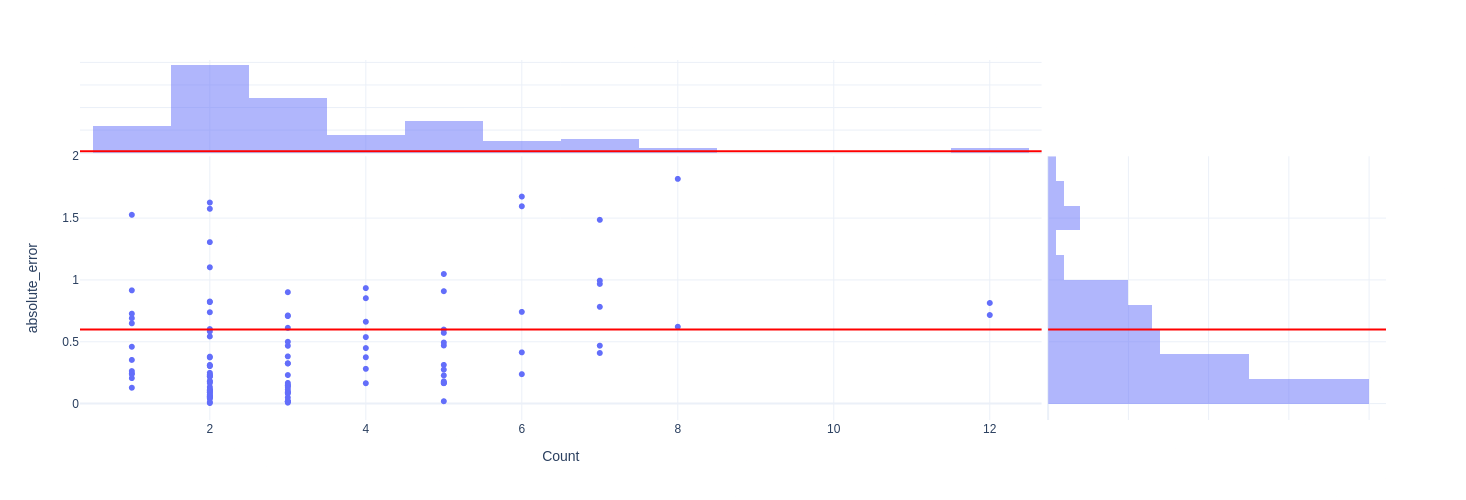

In [31]:
# Plot absolute error in function of the number of substructures
df = data.join(test_attributions.groupby("molecule_smiles").size().to_frame("Count"), on="smiles")

fig = px.scatter(df, x="Count", y="absolute_error", marginal_x="histogram", marginal_y="histogram")
fig.add_hline(y=0.6, line_color="red")
fig.update_layout(autosize=False, width=800, height=500, template="plotly_white")
fig.show()

# Data labeling

In [58]:
molecules = test_attributions[["molecule_smiles", "atom_ids"]].groupby("molecule_smiles")\
    .apply(lambda group: {tuple(key): 1 for key in group.atom_ids})\
    .to_frame("atom_highlights")\
    .reset_index()
molecules

,molecule_smiles,atom_highlights
0,BrCCBr,"{(0,): 1, (3,): 1, (1, 2): 1}"
1,Brc1cc(Br)c(Br)cc1Br,"{(0,): 1, (4,): 1, (6,): 1, (9,): 1, (1, 2, 3,..."
2,Brc1cccc(Br)c1,"{(0,): 1, (6,): 1, (1, 2, 3, 4, 5, 7): 1}"
3,Brc1cccc2ccccc12,"{(0,): 1, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 1}"
4,C#CCCCCCCC,"{(1, 0): 1, (2, 3, 4, 5, 6, 7, 8): 1}"
...,...,...
107,c1ccc2c(c1)CCCC2,"{(0, 1, 2, 3, 4, 5, 6, 7, 8, 9): 1}"
108,c1ccc2c(c1)CCN2,"{(0, 1, 2, 3, 4, 5, 6, 7, 8): 1}"
109,c1ccc2c(c1)Cc1cc3ccccc3cc1-2,"{(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
110,c1ccc2c3c(ccc2c1)-c1cccc2cccc-3c12,"{(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12
{(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19): 1}


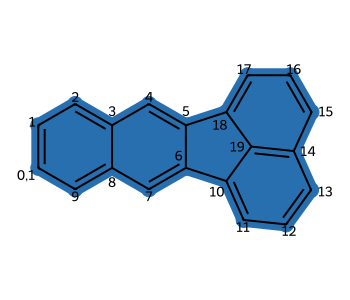

In [112]:
molecule = molecules.iloc[111]
print(molecule.molecule_smiles)
print(molecule.atom_highlights)
XAIChem.showMolecule(
    Chem.MolFromSmiles(molecule.molecule_smiles), 
    molecule.atom_highlights,
    show_atom_indices=True
)

In [42]:
pd.DataFrame.from_dict({
    "Manual_rank": {
        "O=C1C(Cl)C(CCl)CN1c1cccc(C(F)(F)F)c1": {(1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 18): 1, (14, 15, 16, 17): 2, (6,): 3, (3,): 4, (0,): 5},
        "O=C1C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl)C1(Cl)C5(Cl)C24Cl": {
            (1, 2, 4, 6, 8, 11, 13, 15, 17, 19): 1, (3,): 6.5, (5,): 6.5, (7,): 6.5, (9,): 6.5, (10,): 6.5, (12,): 6.5, (14,): 6.5, (16,): 6.5, (18,): 6.5, (20,): 6.5, (0,): 12
        },
        "O=C1CN(N=Cc2ccc([N+](=O)[O-])o2)C(=O)N1": {(10, 11, 12): 1, (1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 16): 1, (0,): 3.5, (15,): 3.5},
        "O=C1NCCN1c1ncc([N+](=O)[O-])s1": {(10, 11, 12): 1, (1, 2, 3, 4, 5, 6, 7, 8, 9, 13): 2, (0,): 3},
        "O=Cc1ccco1": {(1, 2, 3, 4, 5, 6): 1, (0,): 2},
        "O=[N+]([O-])c1ccc(Cl)c(Cl)c1": {(3, 4, 5, 6, 8, 10): 1, (1, 0, 2): 2, (7,): 3.5, (9,): 3.5},
        "O=[N+]([O-])c1cccc2ccccc12": {(3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 1, (1, 0, 2): 2},
        "O=[N+]([O-])c1ccccc1": {(3, 4, 5, 6, 7, 8): 1, (1, 0, 2): 2},
        "O=[N+]([O-])c1ccccc1Cl": {(3, 4, 5, 6, 7, 8): 1, (1, 0, 2): 2, (9,): 3},
        "O=c1[nH]c2c(c(=O)n1C1CCCCC1)CCC2": {(8, 9, 10, 11, 12, 13): 1, (0, 1, 2, 3, 4, 5, 6, 7, 14, 15, 16): 2},
        "OCC1OC(O)(CO)C(O)C1O": {(1, 2, 3, 4, 6, 8, 10): 1, (0,): 4, (5,): 4, (7,): 4, (9,): 4, (11,): 4},
        "OCC1OC(OCC2OC(OC3(CO)OC(CO)C(O)C3O)C(O)C(O)C2O)C(O)C(O)C1O": {
            (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32): 1, (0,): 7, (13,): 7, (17,): 7, (19,): 7, (21,): 7, (23,): 7, (25,): 7, (27,): 7, 
            (29,): 7, (31,): 7, (33,): 7,
        },
        "OCC1OC(n2cnc3c(O)ncnc32)C(O)C1O": {(1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17): 1, (0,): 3.5, (10,): 3.5, (16,): 3.5, (18,): 3.5},
        "Oc1cc(Cl)c(Cl)cc1Cl": {(1, 2, 3, 5, 7, 8): 1, (4,): 3, (6,): 3, (9,): 3, (0,): 5},
        "Oc1ccccc1Cl": {(1, 2, 3, 4, 5, 6): 1, (7,): 2, (0,): 3},
        "Oc1ccccn1": {(1, 2, 3, 4, 5, 6): 1, (0,): 2},
        "c1ccc(C2CO2)cc1": {(0, 1, 2, 3, 7, 8): 1, (4, 5, 6): 2},
        
        
    }
})

,Manual_rank
BrCCBr,"{(0,): 1, (1, 2): 2, (3,): 1}"


In [99]:
from scipy.stats import rankdata

rankdata([1, *[3]*11])

array([1., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.])